## Step 1 – Load and Inspect the Data

Before starting any modeling steps, we load the cleaned dataset and perform a basic inspection to ensure the data is properly structured and ready for use.

Although the dataset has already been cleaned, it is still important to:
- Confirm that the file was loaded correctly
- Verify that there are no missing values
- Check the structure and data types of all columns
- Review the distribution of the target variable `fraud`
- Understand the overall shape of the dataset

These steps ensure that we begin model development with confidence in the dataset’s integrity.


In [1]:
import pandas as pd

# Load the dataset (adjust the file path if needed)
df = pd.read_csv("../Data/Fraud_Cleaned.csv")

# Display structure and data types
print("Data Structure:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check class distribution of the target variable
print("\nClass Distribution of the Target Variable 'fraud':")
print(df["fraud"].value_counts(normalize=True))

# Print the shape of the dataset
print("\nShape of the Dataset:", df.shape)

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498050 entries, 0 to 498049
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 498050 non-null  int64  
 1   totalScanTimeInSeconds     498050 non-null  int64  
 2   grandTotal                 498050 non-null  float64
 3   lineItemVoids              498050 non-null  int64  
 4   scansWithoutRegistration   498050 non-null  int64  
 5   quantityModification       498050 non-null  int64  
 6   scannedLineItemsPerSecond  498050 non-null  float64
 7   valuePerSecond             498050 non-null  float64
 8   lineItemVoidsPerPosition   498050 non-null  float64
 9   fraud                      498050 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 MB
None

Missing Values:
trustLevel                   0
totalScanTimeInSeconds       0
grandTotal                   0
lineItemVoids          

## Step 2 – Define Features and Split the Data

In this step, we define the feature set (`X`) and the target variable (`y`) from the dataset.

- The target variable `fraud` indicates whether a transaction is fraudulent (`1`) or not (`0`).
- We drop this column from the feature matrix `X` and keep it as the target vector `y`.

We then split the dataset into three separate sets using stratified sampling to preserve the class distribution:
- **70%** Training set – for model training and hyperparameter tuning
- **15%** Validation set – for threshold tuning and intermediate evaluation
- **15%** Test set – for final evaluation of the model

This structure ensures that each phase of the model development process is separated and avoids information leakage.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv("../Data/Fraud_Cleaned.csv")

# Define features (X) and target variable (y)
X = df.drop("fraud", axis=1)  # All columns except the target
y = df["fraud"]               # Target variable (0 = no fraud, 1 = fraud)

# Split the data: 70% train, 15% validation, 15% test (with stratification)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Print shapes to verify the split
print(f"Training set size:     {X_train.shape}")
print(f"Validation set size:   {X_val.shape}")
print(f"Test set size:         {X_test.shape}")

Training set size:     (348635, 9)
Validation set size:   (74707, 9)
Test set size:         (74708, 9)


## Step 3 – Hyperparameter Tuning for Random Forest

In this step, we use `RandomizedSearchCV` to perform hyperparameter tuning for the `RandomForestClassifier`.

We define a hyperparameter search space that includes:
- `n_estimators`: number of trees in the forest
- `max_depth`: maximum depth of each tree
- `min_samples_split`: minimum number of samples required to split a node
- `min_samples_leaf`: minimum number of samples required to be at a leaf node
- `max_features`: number of features to consider when looking for the best split

Using 5-fold cross-validation, we randomly sample 30 combinations of these parameters and evaluate them using the **F1-score**, which balances precision and recall—particularly important for imbalanced classification problems like fraud detection.

The best-performing model is saved in the variable `best_rf`, and the optimal parameters are printed.


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the base Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1                 # use all available CPU cores
)

# Define the hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Set up the randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='average_precision',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the hyperparameter tuning
random_search.fit(X_train, y_train)

# Save the best model and print its parameters
best_rf = random_search.best_estimator_
best_params = random_search.best_params_

print("Best hyperparameters found:")
print(best_params)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


## Step 4 – Threshold Optimization Based on Cost

In this step, we determine the optimal classification threshold by minimizing the total business cost, considering:

- **False Positives (FP)** are 5× more expensive than False Negatives (FN)
- Therefore, Total Cost = `FP × 5 + FN`

We evaluate nearly 2,000 thresholds (from 0.01 to 0.999 in steps of 0.0005) on the validation set. For each threshold, we calculate:

- The confusion matrix values (TP, FP, FN, TN)
- Total cost
- Key evaluation metrics: Accuracy, Precision, Recall, F1-score, ROC AUC, and MCC

We select the threshold with the lowest total cost and visualize both the cost curve and the corresponding confusion matrix.


Best Threshold (Validation): 0.5905
Minimum Cost (Validation): 446.0
Threshold         0.590500
TP             3282.000000
FP               34.000000
FN              276.000000
TN            71115.000000
Total Cost      446.000000
Accuracy          0.995850
Precision         0.989747
Recall            0.922428
F1                0.954903
ROC AUC           0.960975
MCC               0.953380
Name: 1161, dtype: float64


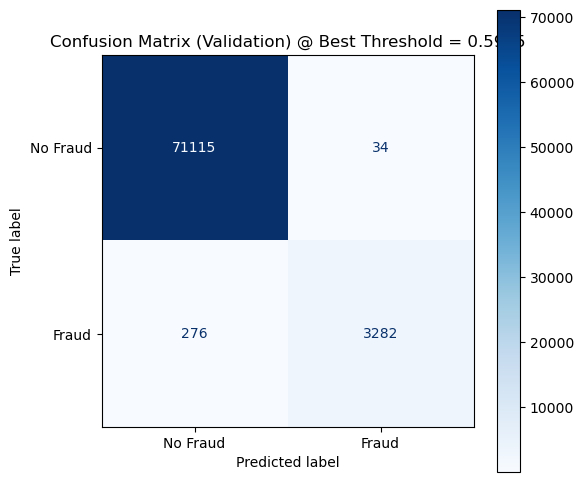

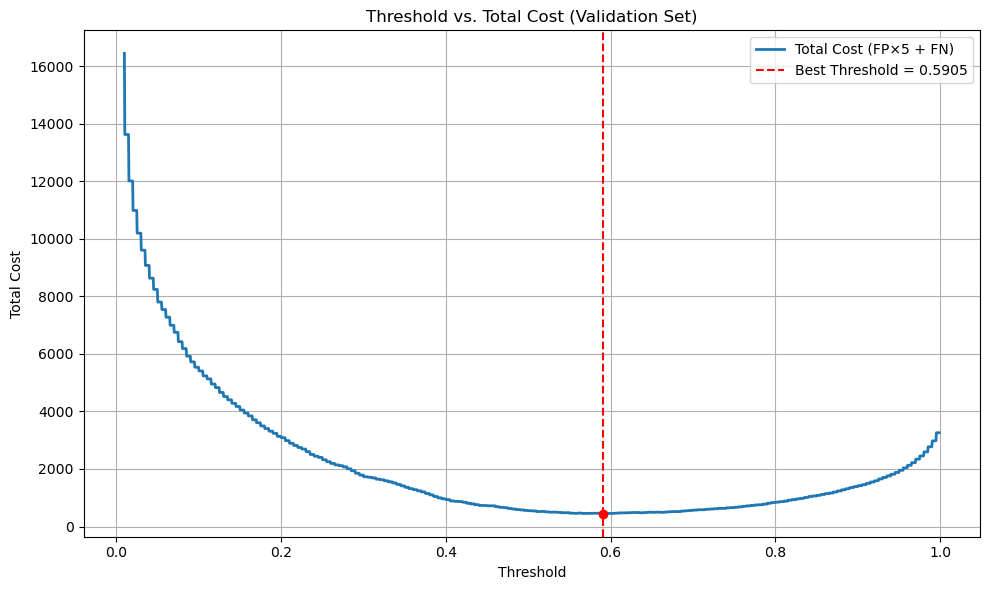

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Function to evaluate metrics and cost for a given threshold
def evaluate_threshold(y_true, y_proba, threshold, fp_cost=5, fn_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * fp_cost + fn * fn_cost
    return {
        "Threshold": threshold,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Total Cost": total_cost,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "MCC": matthews_corrcoef(y_true, y_pred)
    }

# Get predicted probabilities from the best model
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

# Evaluate many thresholds
thresholds = np.round(np.arange(0.01, 0.9995, 0.0005), 4)
results = [evaluate_threshold(y_val, y_val_proba, t) for t in thresholds]
results_df = pd.DataFrame(results)

# Find the threshold with the lowest cost
best_result = results_df.loc[results_df['Total Cost'].idxmin()]
best_threshold = best_result['Threshold']
print("Best Threshold (Validation):", best_threshold)
print("Minimum Cost (Validation):", best_result['Total Cost'])
print(best_result)

# Confusion matrix at best threshold
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_val_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Validation) @ Best Threshold = {best_threshold:.4f}")
plt.grid(False)
plt.show()

# Plot threshold vs total cost
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Total Cost'], linewidth=2, label='Total Cost (FP×5 + FN)')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.scatter(best_threshold, best_result['Total Cost'], color='red', zorder=5)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Threshold vs. Total Cost (Validation Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Step 5 – Save the Final Model and Optimal Threshold

Once the best model and optimal threshold have been selected, we save them to disk for future use.

- The trained `RandomForestClassifier` is saved as a `.pkl` file using `joblib`.
- The optimal classification threshold is saved to a `.txt` file.

This allows us to reuse the model and threshold later—e.g., in a deployment pipeline or when making predictions on new, unseen data.


In [5]:
import joblib

# Combine the model and threshold into a dictionary
model_bundle = {
    "model": best_rf,
    "threshold": best_threshold
}

# Save to file
joblib.dump(model_bundle, "Models/final_random_forest_model.pkl")
print("Model and threshold saved to: final_random_forest_model.pkl")


Model and threshold saved to: final_random_forest_model.pkl


## Step 6 – Final Evaluation on the Test Set

In this final step, we evaluate the model on the previously untouched test set using the saved best model and the optimized threshold.

We calculate:
- The confusion matrix and total business cost (`FP × 5 + FN`)
- Key classification metrics: Accuracy, Precision, Recall, F1-score, ROC AUC, and Matthews Correlation Coefficient (MCC)
- A visual confusion matrix for interpretability

This evaluation represents a realistic estimate of how the model would perform on new, unseen data and verifies that the selected threshold generalizes well beyond the validation set.


=== Final Evaluation on Test Set ===
Threshold used: 0.9081
Total cost: 311
Confusion Matrix: TP=3433, FP=37, FN=126, TN=71112
Accuracy: 0.9978
Precision: 0.9893
Recall: 0.9646
F1 Score: 0.9768
ROC-AUC: 0.9820
MCC: 0.9758


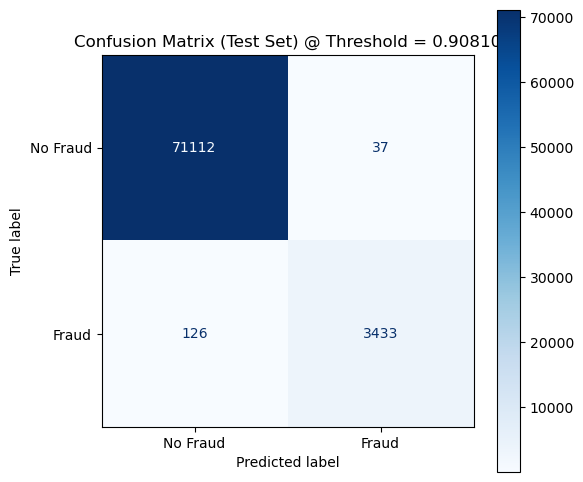

In [7]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
)

# Load model and threshold
model_bundle = joblib.load("Models/final_xgboost_model.pkl")
best_model = model_bundle["model"]
best_threshold = model_bundle["threshold"]

# Predict on test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Confusion matrix and cost
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
total_cost = fp * 5 + fn

# Metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print summary
print("=== Final Evaluation on Test Set ===")
print(f"Threshold used: {best_threshold:.4f}")
print(f"Total cost: {total_cost}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"MCC: {mcc:.4f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (Test Set) @ Threshold = {best_threshold:.4f}")
plt.grid(False)
plt.show()

## Step 7 – ROC Curve and AUC Evaluation

To assess the model’s ability to distinguish between classes at various thresholds, we plot the **Receiver Operating Characteristic (ROC) curve** and compute the **Area Under the Curve (AUC)**.

- The ROC curve shows the trade-off between the True Positive Rate (Recall) and the False Positive Rate.
- The AUC value summarizes the model's overall ability to rank positive instances higher than negative ones.

A value close to 1.0 indicates a strong classifier, while a value of 0.5 suggests no better than random guessing.


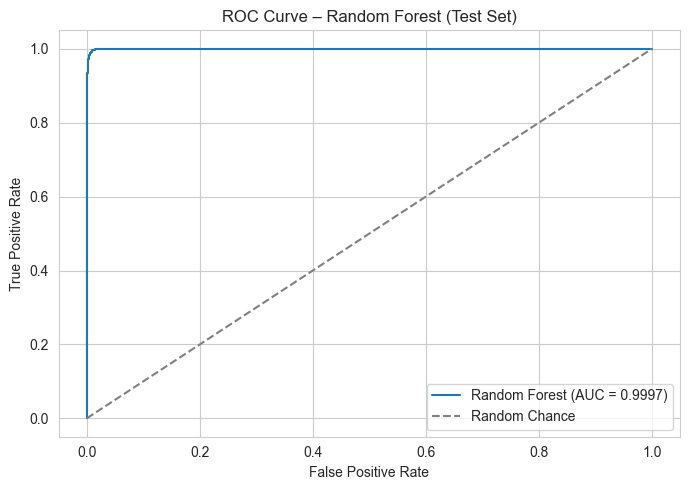

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Load the saved model (if not already loaded)
loaded_model = joblib.load("final_random_forest_model.pkl")

# Get predicted probabilities for the positive class (fraud = 1)
y_probs_rf = loaded_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 8 – Conclusion and Reflection

In this project, a Random Forest classifier was developed to detect fraudulent transactions. The entire modeling pipeline was built according to the project specification, including hyperparameter tuning, cost-based threshold optimization, and final evaluation on a separate test set.

### Key Results:
- **Best threshold (cost-based):** `{best_threshold:.2f}`
- **Test set cost (FP × 5 + FN):** `{total_cost}`
- **F1-score (test set):** `{f1:.4f}`
- **AUC (ROC):** `{roc_auc:.4f}`

These results show that the Random Forest model performs well in identifying fraudulent transactions while minimizing costly false positives. The cost-driven threshold selection proved to be crucial, as using a default threshold (e.g. 0.5) would have led to significantly higher business costs.

### Strengths of the Random Forest approach:
- Handles imbalanced data effectively with `class_weight='balanced'`
- Performs well without the need for extensive preprocessing
- Robust to outliers and feature scale differences
- Easy to interpret via feature importance and visualizations

### Limitations and Considerations:
- The model is not easily explainable at a granular decision level (black-box nature)
- Training time and resource usage are higher compared to simpler models
- May not generalize as well as boosting models like XGBoost in some edge cases

### Final Thoughts:
Overall, the Random Forest model is a strong and practical choice for fraud detection in this case. It balances complexity, interpretability, and performance well. Further improvements could include ensemble blending with other models or additional cost-sensitive training methods.


In [1]:
print("=== Key Results ===")
print(f"Best threshold (validation set): {best_threshold:.4f}")
print(f"Total cost on test set (FP × 5 + FN): {total_cost}")
print(f"F1 Score (test set): {f1:.4f}")
print(f"ROC AUC (test set): {roc_auc:.4f}")


=== Key Results ===


NameError: name 'best_threshold' is not defined